In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
display.set_matplotlib_formats('svg')

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

/var/folders/nn/4_714bpd2qz7gm9d27_r3qw40000gn/T/ipykernel_27767/3922022940.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


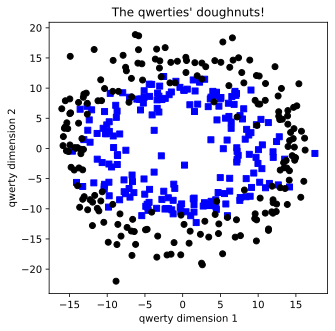

In [25]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batchsize = int(train_data.tensors[0].shape[0]/ 4)
train_loader = DataLoader(train_data, shuffle = True, batch_size = batchsize)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [32]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        
        self.dr = dropoutRate
        
    def forward(self, x):
        x = F.relu(self.input(x))
        
        x = F.dropout(x, p = self.dr, training = self.training)
        
        x = F.relu(self.hidden(x))
        
        x = F.dropout(x, p = self.dr, training = self.training)
        
        x = self.output(x)
        
        return x

In [33]:
# test the model
tmpnet = theModelClass(0.25)

# run some random data through
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.1418],
        [ 0.0705],
        [ 0.0805],
        [ 0.0104],
        [ 0.0395],
        [ 0.0069],
        [ 0.0754],
        [-0.0462],
        [ 0.0613],
        [-0.0086]], grad_fn=<AddmmBackward0>)

In [43]:
def createModel(dropoutRate):
    ANNclassifier = theModelClass(dropoutRate)
    
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANNclassifier.parameters(), lr = 0.01)
    
    return ANNclassifier, lossfun, optimizer

In [44]:
numepochs = 1000

def trainModel(model, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    
    
    for epochi in range(numepochs):
        model.train()
        batchAcc = []
        for X, y in train_loader:
            yHat = model(X)
            
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        model.eval() # switch training off
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        yHat = model(X)
        testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
  
    # function output
    return trainAcc,testAcc


In [45]:
# create a model
dropoutrate = .0
ANNQC,lossfun,optimizer = createModel(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = trainModel(ANNQC,lossfun,optimizer)

In [46]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

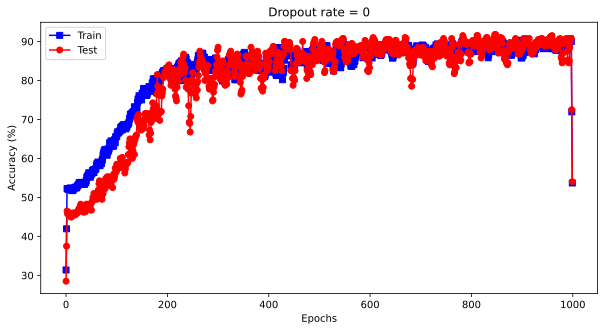

In [47]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [48]:
# run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):
    # create and train the model
    ANNQC,lossfun,optimizer = createModel(dropoutRates[di])
    trainAcc,testAcc = trainModel(ANNQC,lossfun,optimizer)

    # store accuracies from last 100 epochs
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])


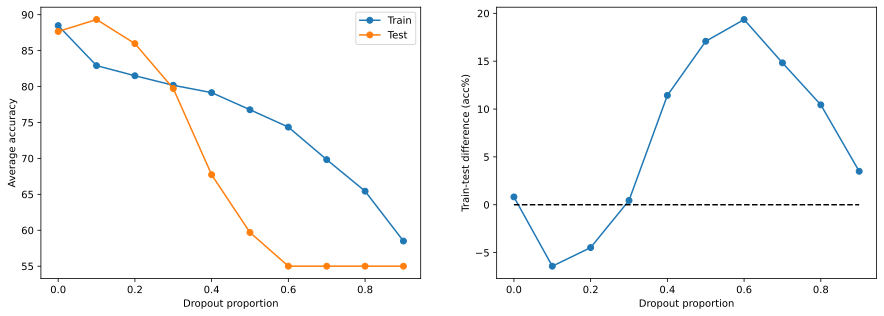

In [49]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()